## Sampling from a langue model 

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/notebooks/03_sampling_lmm.ipynb)

The following NB demonstrates the sampling from a causal LLM, like the GPT models.

The idea is to generate a sequence of tokens, one at a time, by sampling from the conditional distribution of the next token given the previous ones. This is done by sampling from the output of the model, which is a probability distribution over the vocabulary.

We start by using very small GTP-2 Models from the `transformers` library of Hugging Face. If you want to use a larger model, you can change the `model_name` to more powerful models.

In [179]:
#load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import os
os.environ["KERAS_BACKEND"] ="torch"
import keras
import torch
print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {torch.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')
import time

# Check for CUDA (NVIDIA GPU) availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ CUDA is available. Using GPU.")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# Check for MPS (Apple Silicon GPU) availability
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ MPS (Apple Silicon GPU) is available. Using MPS.")

# Default to CPU if neither CUDA nor MPS is available
else:
    device = torch.device("cpu")
    print("❌ No GPU available. Using CPU.")

print(f"Device selected: {device}")

Keras_version: 3.8.0
torch_version: 2.5.1
keras backend: torch
✅ MPS (Apple Silicon GPU) is available. Using MPS.
Device selected: mps


## Selecting the model


In [186]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load pretrained model and tokenizer
#model_name = "tiiuae/falcon-7b-instruct" #High mem confing runs ok
model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"  # Quite slow on mac, take more than 5 minutes to load
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B" # Tested on Mac and Colab
model_name = "HuggingFaceTB/SmolLM2-1.7B-Instruct" # Tested on Mac, see https://huggingface.co/HuggingFaceTB/SmolLM2-1.7B-Instruct
model_name = "HuggingFaceTB/SmolLM2-1.7B"  # Tested on Mac, see https://huggingface.co/HuggingFaceTB/SmolLM2-1.7B
model_name = "gpt2" #Runs on standard Colab Instances
#model_name = "TinyLlama/TinyLlama_v1.1"

use_quantized_model = False # Works at colab but currently (Feb 2025) need quite some time for installing

## Tokenization

In [187]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
input_context = "Hello World Hund"
torch.tensor(tokenizer.encode(input_context))
# For GPT2 Tokenization
# 15496 is for 'Hello ' note the trailing white space
#  2159 is for ' World' note the leading white space
#   367 is for ' H'
#   917 is for 'und'

tensor([15496,  2159,   367,   917])

### 🔧 **YOUR TASK:**

- Decode the following token ids (gpt-2) coding

In [188]:
ids = torch.tensor([ 8642,   265,  1741,     0,  6733,   317,  3046,    70, 11231,   318, 83, 20383,  9101,   301, 50169,   237])
ids

tensor([ 8642,   265,  1741,     0,  6733,   317,  3046,    70, 11231,   318,
           83, 20383,  9101,   301, 50169,   237])

In [189]:
# @title 🔑 Solution Code { display-mode: "form" }


# Uncomment the following line
# tokenizer.decode(ids)

## Downloading model

In [190]:
if use_quantized_model:
    !pip install bitsandbytes
    !pip install 'accelerate>=0.26.0'

In [191]:
if (use_quantized_model):
    from transformers import BitsAndBytesConfig
    bnb_config = BitsAndBytesConfig(
              load_in_8bit=True,  # Load model in 8-bit precision
              llm_int8_threshold=6.0  # Threshold for quantization
       )
    model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name)

if (device.type != 'cpu'): #If we are using a GPU move the model to GPU
    print("Moving model to ", device)
    model.to(device)

print(f"Number of Parametes  : {model.num_parameters() / (1E9):.3} Billion") #In Billions note that GPT 3.5 has 175B
print(f"Memory footprint     : {model.get_memory_footprint() / 1e9:.3f} GB")

Moving model to  mps
Number of Parametes  : 0.124 Billion
Memory footprint     : 0.510 GB


In [192]:
#messages = [{"role": "user", "content": "What is the capital of France?"}]
#input_context=tokenizer.apply_chat_template(messages, tokenize=False)
#print(input_context)

In [200]:
input_context = "The weather is really nice today. I'm thinking about going for a"
input_ids = torch.tensor(tokenizer.encode(input_context), device=device).unsqueeze(0)
input_ids, input_ids.shape

(tensor([[ 464, 6193,  318, 1107, 3621, 1909,   13,  314, 1101, 3612,  546, 1016,
           329,  257]], device='mps:0'),
 torch.Size([1, 14]))

## Predicting the next token

In [201]:
start_time = time.time()
outputs = model(input_ids) # We ask the model for the next token
end_time = time.time()

time_next_token = end_time - start_time
print(f"Execution Time: {time_next_token:.3f} seconds")

Execution Time: 0.049 seconds


In [202]:
outputs.logits.shape
# We have 14 entries
# Fhe first are the logits of the next token after 'The'
# The second are the logits of the next token after 'The weather'
# ...
# The last is the next token after 'The weather is really nice today. I'm thinking about going for a'
# This is the only one which matters

torch.Size([1, 14, 50257])

In [203]:
with torch.no_grad():
    next_token_logits = outputs.logits[:, -1, :]
next_token_logits.shape, next_token_logits

(torch.Size([1, 50257]),
 tensor([[-125.7411, -124.9337, -128.9374,  ..., -135.1948, -129.5833,
          -125.4954]], device='mps:0', requires_grad=True))

In [204]:
probs = torch.nn.functional.softmax(next_token_logits, dim=-1)[0]
probs, probs.shape

(tensor([1.7978e-06, 4.0307e-06, 7.3551e-08,  ..., 1.4095e-10, 3.8557e-08,
         2.2986e-06], device='mps:0', grad_fn=<SelectBackward0>),
 torch.Size([50257]))

In [205]:
# Find the indices that would sort the probabilities in descending order
sorted_indices = torch.argsort(probs, dim=-1, descending=True)
top_indices = sorted_indices[:10]

cumulative_prob = 0
for index in top_indices:
  token = tokenizer.decode(index.item())
  probability = probs[index].item()
  cumulative_prob += probability
  print(f"Token: '{token}', Probability: {probability}, Cummulative: {cumulative_prob}")

Token: ' walk', Probability: 0.16972596943378448, Cummulative: 0.16972596943378448
Token: ' swim', Probability: 0.13210609555244446, Cummulative: 0.30183206498622894
Token: ' run', Probability: 0.07447320967912674, Cummulative: 0.3763052746653557
Token: ' hike', Probability: 0.05188329890370369, Cummulative: 0.42818857356905937
Token: ' jog', Probability: 0.04039442539215088, Cummulative: 0.46858299896121025
Token: ' drive', Probability: 0.014344843104481697, Cummulative: 0.48292784206569195
Token: ' long', Probability: 0.014177504926919937, Cummulative: 0.4971053469926119
Token: ' stroll', Probability: 0.013317110016942024, Cummulative: 0.5104224570095539
Token: ' ride', Probability: 0.011630465276539326, Cummulative: 0.5220529222860932
Token: ' day', Probability: 0.009953150525689125, Cummulative: 0.5320060728117824


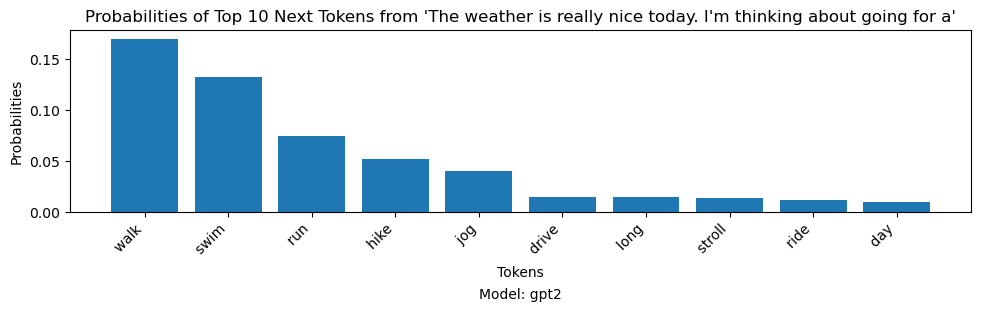

[' walk',
 ' swim',
 ' run',
 ' hike',
 ' jog',
 ' drive',
 ' long',
 ' stroll',
 ' ride',
 ' day']

In [206]:
import matplotlib.pyplot as plt
top_indices = sorted_indices[:10]

tokens = []
probabilities = []
for index in top_indices:
  token = tokenizer.decode(index.item())
  probability = probs[index].item()
  tokens.append(token)
  probabilities.append(probability)


# 
# Add dataset information as text within the plot
text_info = f"Model: {model_name}\n"
text_info


plt.figure(figsize=(10, 3))
plt.bar(tokens, probabilities)
plt.xlabel("Tokens")
plt.ylabel("Probabilities")
plt.title(f"Probabilities of Top 10 Next Tokens from '{input_context}'")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.text(0.5, -0.5, text_info, ha='center', va='center', transform=plt.gca().transAxes)  # Adjust position as needed
plt.show()
tokens


## Sampling a sequence

### Basic Idea to sample t

In [207]:
from torch.distributions import Categorical
from collections import Counter

# Create a categorical distribution based on the logits
categorical_dist = Categorical(logits=next_token_logits)

# Sample from the distribution
sampled_index = categorical_dist.sample()

# Decode the sampled index to get the actual token
sampled_token = tokenizer.decode(sampled_index.item())
print("Sampled token:", sampled_token)

Sampled token:  walk


In [208]:
sampled_tokens = []
for _ in range(100):
    sampled_index = categorical_dist.sample()
    sampled_token = tokenizer.decode(sampled_index.item())
    sampled_tokens.append(sampled_token)

# Create a frequency table
frequency_table = Counter(sampled_tokens)

# Sort the frequency table by frequency in descending order
sorted_frequency_table = dict(sorted(frequency_table.items(), key=lambda item: item[1], reverse=True))

# Display the top-5 frequencies
for token, freq in list(sorted_frequency_table.items())[:10]:
    print(f"Token: '{token}', Frequency: {freq}")

Token: ' walk', Frequency: 16
Token: ' swim', Frequency: 14
Token: ' run', Frequency: 11
Token: ' hike', Frequency: 9
Token: ' jog', Frequency: 4
Token: ' day', Frequency: 3
Token: ' drive', Frequency: 2
Token: ' dip', Frequency: 2
Token: ' ride', Frequency: 2
Token: ' short', Frequency: 2


In [209]:
# Function to apply top-k, top-p, and min-p filtering
def filter_logits(logits, top_k=-1, top_p=2.0, min_p=0.0):
    logits = logits.clone()

    # Apply top-k: Keep only the top k logits
    if top_k > 0:
        top_k_values, _ = torch.topk(logits, top_k)
        min_top_k_logit = top_k_values[:, -1].unsqueeze(-1)
        logits[logits < min_top_k_logit] = -float('Inf')

    # Apply top-p (nucleus sampling)
    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
        sorted_indices_to_remove = cumulative_probs > top_p
        if sorted_indices_to_remove[:, 0].any():
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = False
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = -float('Inf')

    # Apply min-p: Remove tokens below a minimum probability
    probs = torch.softmax(logits, dim=-1)
    logits[probs < min_p] = -float('Inf')

    return logits

In [210]:
from IPython.display import display, Markdown, clear_output
# Input context
#input_context = "What is seq(1,10,0.1) in python"
#input_context = "x^16/x^4"
#input_context = "The weather is really nice today. I'm thinking about going for a"
#input_context = "What is good enough in Chinese, give charaters and Pinyin"
#input_context = "Solve for  x  in the equation  2x + 5 = 13 ." #Works with DeepSeek-R1-Distill-Qwen-1.5B
#input_context = "What is the capital of France? Just the answer, please."


# Typical settings for temperature, top-k, top-p, and min-p
temperature = 0.2
top_k=50
top_p=0.95
min_p=0.01

# No temperature scaling and no filtering
# temperature = 0.7
# top_k=-50
# top_p=100
# min_p=0.0

input_ids = torch.tensor(tokenizer.encode(input_context), device=device).unsqueeze(0)
# EOS token ID
eos_token_id = tokenizer.eos_token_id
print(f"EOS Token ID: {eos_token_id}")

# Function to sample the next token
def sample_next_token(input_ids):
    with torch.no_grad():  # Disable gradient calculation for evaluation
        outputs = model(input_ids)
    next_token_logits = outputs.logits[:, -1, :]

    # Deterministic (greedy) decoding if temperature is 0
    if temperature == 0.0:
        sampled_index = torch.argmax(next_token_logits, dim=-1)
        return sampled_index.item()

    # Apply temperature scaling
    scaled_logits = next_token_logits / temperature

    # Apply top-k, top-p, and min-p filtering
    filtered_logits = filter_logits(scaled_logits, top_k=top_k, top_p=top_p, min_p=min_p)

    # Sample from the filtered distribution
    categorical_dist = Categorical(logits=filtered_logits)
    sampled_index = categorical_dist.sample()

    return sampled_index.item()

# Generate text until EOS token is reached
generated_text = input_context
new_text = "" 
num_tokens_to_generate = 50  # Max tokens to generate if EOS not encountered

start_time = time.time()
num_tokens = 0
for i in range(num_tokens_to_generate):
    sampled_token_index = sample_next_token(input_ids)

    if sampled_token_index == eos_token_id:
        display("\n[End of Sequence Token Generated]")
        break

    num_tokens += 1

    sampled_token = tokenizer.decode([sampled_token_index], clean_up_tokenization_spaces=True)

    clear_output(wait=True)
    display(f"{i + 1}. Next token: {sampled_token_index} '{sampled_token}'")
    display(f"{generated_text + sampled_token}")
    
    generated_text += sampled_token
    new_text += sampled_token
    
    input_ids = torch.cat([input_ids, torch.tensor([[sampled_token_index]], device=device)], dim=1)

    
time_taken = time.time() - start_time
print("\nFinal Generated Text:\n", generated_text, f" {i} tokens in {time_taken:.3f} seconds")


"50. Next token: 3155 ' couple'"

"The weather is really nice today. I'm thinking about going for a walk in the woods. I'm going to be back in a couple of weeks. I'm going to be back in a couple of weeks. I'm going to be back in a couple of weeks. I'm going to be back in a couple"


Final Generated Text:
 The weather is really nice today. I'm thinking about going for a walk in the woods. I'm going to be back in a couple of weeks. I'm going to be back in a couple of weeks. I'm going to be back in a couple of weeks. I'm going to be back in a couple  49 tokens in 3.993 seconds


In [211]:
from IPython.display import display, Markdown

output_text = f"""
**Model:** {model_name}  

**Temperature:** {temperature}

**Top-K:** {top_k}  

**Top-P:** {top_p}  

**Min-P:** {min_p}

**Tokens / Second:** {time_taken/num_tokens:.3f} seconds

<hr/>

**Prompt:** <span style="color:green">{input_context}</span>  

**Generated Text:**  
{new_text}
"""

display(Markdown(output_text))


**Model:** gpt2  

**Temperature:** 0.2

**Top-K:** 50  

**Top-P:** 0.95  

**Min-P:** 0.01

**Tokens / Second:** 0.080 seconds

<hr/>

**Prompt:** <span style="color:green">The weather is really nice today. I'm thinking about going for a</span>  

**Generated Text:**  
 walk in the woods. I'm going to be back in a couple of weeks. I'm going to be back in a couple of weeks. I'm going to be back in a couple of weeks. I'm going to be back in a couple


### 🔧 **YOUR TASK:**

- Change the temperature to different values what do you observe? Also change the prompt to e.g. "What is the capital of France."

- If time, change model to a more powerfull model like: 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B'

### Bonus Visualization of the Embedding 🌟✨

Note that the embeddings work with GPT-2 but not with all other models.

In [212]:
# Function to get static embeddings from the embedding layer
def get_static_embeddings(input_ids):
    # Access the embedding layer directly
    with torch.no_grad():
        static_embeddings = model.transformer.wte(input_ids)
    
    return static_embeddings.squeeze(0)  # Shape: [sequence_length, hidden_size]

# Example usage
text = "Data science and deep learning"
static_embeddings = get_static_embeddings(torch.tensor([1,2,3], device=device))
print(static_embeddings[0,0:5])
get_static_embeddings(torch.tensor([2,1,3],device=device))[1,0:5]


tensor([ 0.0403, -0.0486,  0.0462, -0.0990,  0.0826], device='mps:0')


tensor([ 0.0403, -0.0486,  0.0462, -0.0990,  0.0826], device='mps:0')

python(82463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


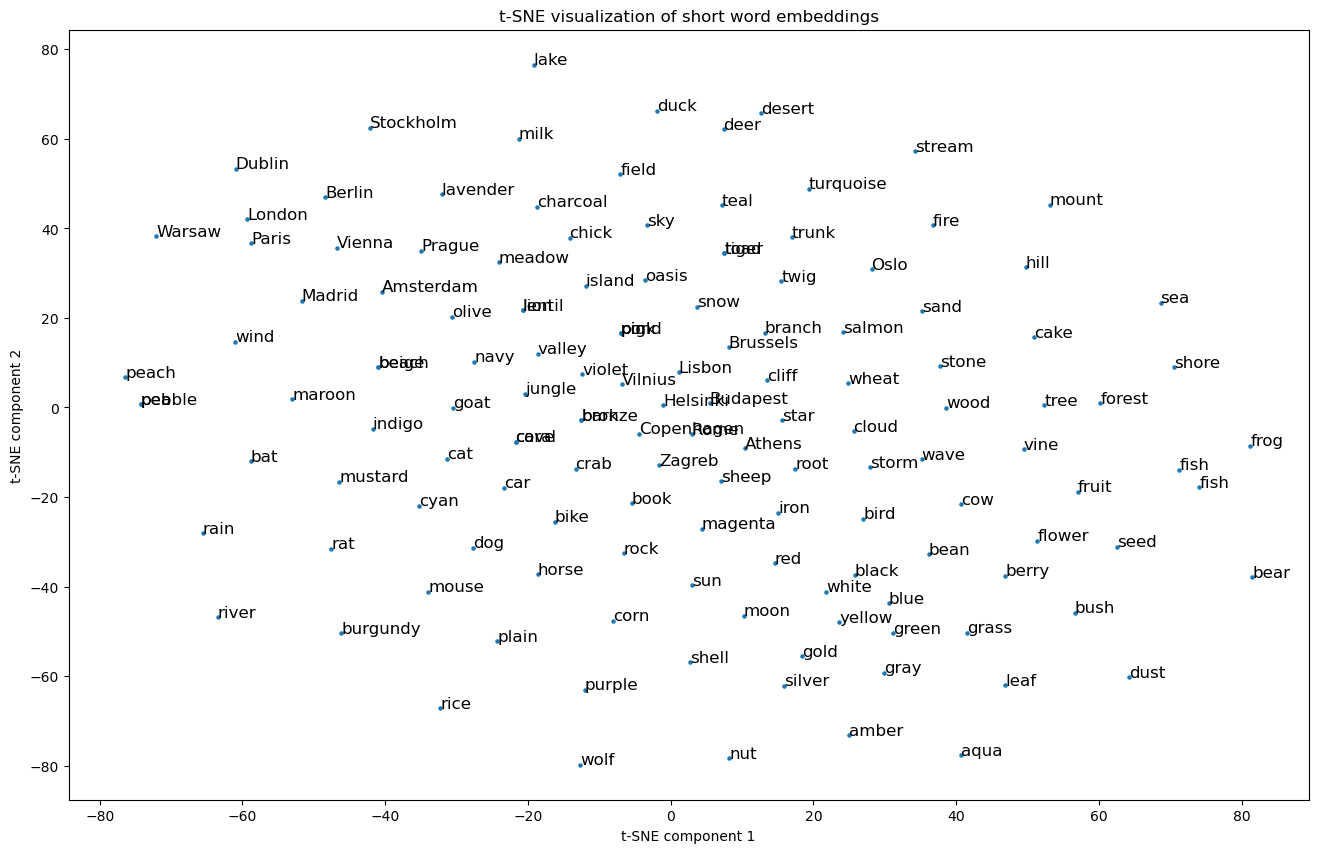

In [213]:
from sklearn.manifold import TSNE
words = [
    "cat", "dog", "fish", "bird", "tree", "book", "car", "bike", "milk", "cake",
    "rain", "snow", "wind", "fire", "star", "moon", "sun", "sky", "blue", "red",
    "green", "yellow", "black", "white", "pink", "gray", "gold", "silver", "bronze",
    "iron", "wood", "rock", "sand", "dust", "cloud", "storm", "wave", "sea", "lake",
    "pond", "river", "stream", "hill", "mount", "valley", "plain", "field", "meadow",
    "forest", "jungle", "desert", "oasis", "island", "beach", "shore", "cliff", "cave",
    "stone", "pebble", "shell", "leaf", "flower", "grass", "bush", "vine", "root",
    "branch", "twig", "bark", "trunk", "seed", "fruit", "berry", "nut", "corn", "wheat",
    "rice", "bean", "pea", "lentil", "chick", "duck", "goat", "sheep", "cow", "horse",
    "pig", "deer", "bear", "wolf", "lion", "tiger", "mouse", "rat", "bat", "frog",
    "toad", "crab", "fish",

    # 20 European Capitals
    "London", "Paris", "Berlin", "Rome", "Madrid", "Lisbon", "Vienna", "Prague",
    "Budapest", "Warsaw", "Athens", "Copenhagen", "Helsinki", "Stockholm", "Oslo",
    "Brussels", "Amsterdam", "Dublin", "Vilnius", "Zagreb",

    # Additional Colors
    "purple", "turquoise", "navy", "maroon", "beige", "cyan", "magenta", "lavender",
    "teal", "olive", "amber", "indigo", "coral", "aqua", "violet", "burgundy",
    "charcoal", "mustard", "peach", "salmon"
]

# Get embeddings for the filtered short words
short_word_embeddings = []
for word in words:
    token_id = tokenizer.encode(word, add_special_tokens=False)[0]
    embedding = get_static_embeddings(torch.tensor([token_id], device=device))
    short_word_embeddings.append(embedding.cpu().numpy())

# Convert to numpy array
short_word_embeddings = np.array(short_word_embeddings).squeeze()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(short_word_embeddings)

# Plot the results
plt.figure(figsize=(16, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5)

# Annotate the points with the words
for i, word in enumerate(words):
    plt.annotate(word, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=12)

plt.title("t-SNE visualization of short word embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()